# Random Forest & XGBoost Analysis

A comparitive analysis of the main regression models under consideration for selection, i.e. Random Forest and XGBoost.

In [2]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import warnings
import time

import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SequentialFeatureSelector

# Metrics
from sklearn import metrics
from sklearn.decomposition import PCA

# Feature importance visulization
from xgboost import plot_importance
#import shap

In [3]:
# Options
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Load Data

In [4]:
# Load FL/TX data
df_full = pd.read_csv("../data/open-fema/FEMA-Large-Demographics-FL-TX.csv")
print('With outliers:', len(df_full))

# Load clean FL/TX data
df_clean = pd.read_csv("../data/open-fema/FEMA-Large-Demographics-FL-TX-clean.csv")
print('Without outliers:', len(df_clean))

With outliers: 3535319
Without outliers: 3187285


In [9]:
def transform_fema(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.
    '''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

## Random Forest Regressor

https://machinelearningmastery.com/random-forest-ensemble-in-python/

- The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the size of the training dataset to make the bootstrap sample used to train each decision tree.
- max_features argument and defaults to the square root of the number of input features. 
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default.

In [15]:
# Best parameters using IHP GridSearch with min samples leaf
# Obtained from DecisionTrees notebook

# {'bootstrap': True,
# 'max_depth': 10,
# 'max_samples': 0.8,
# 'min_samples_leaf': 10,
# 'n_estimators': 75}

In [188]:
def random_forest(data=df_full, n_estimators=75, max_depth=10, max_samples=0.8, min_samples_leaf=10, criterion='mse', bootstrap=True):
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'haAmount']
    y = data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # Gradient Boosting - fit the model
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               max_samples=max_samples,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap=bootstrap,
                               criterion=criterion,
                               random_state=42)
    rf.fit(X_train, y_train)

    # Predict
    y_pred = rf.predict(X_test)
    
    # Parameters and results
    print('Random Forest Regressor')
    print('Features: {}'.format(X_train.shape[1]))
    print('Time (minutes): {:.1f}'.format((time.time() - start_time)/60))
    
    print('\nR^2 score: {:.4f}'.format(metrics.r2_score(y_test, y_pred)))
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    # Dollar amounts
    print('\nActual amount:    ${:,.2f}'.format(y_test.sum()))
    print('Predicted amount: ${:,.2f}'.format(y_pred.sum()))
    print('Difference: {:,.2f}'.format(y_pred.sum() - y_test.sum()))
    
    # Predictions off by more than 20%
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['diff'] = results_df['predicted'] - results_df['actual']    
    results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)    
    print('\nPreds off by 20%: {:.2f}%'.format( 
          len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100))  
    
    return(rf, y_pred, y_test)

### Full Data - RF

In [81]:
# Transform
df = transform_fema(df_full)

# RandomForest - full data
rf, y_pred_rf, y_test_rf = random_forest(data=df, n_estimators=75,
                                                  max_depth=10,
                                                  max_samples=0.8,
                                                  min_samples_leaf=1,
                                                  bootstrap=True)

# Save the model
pickle.dump(rf, open('./models/rf.sav', 'wb'))

Random Forest Regressor
Features: 34
Time (minutes): 14.2

R^2 score: 0.9542
MAE: 72.88
MSE: 293376.69
RMSE: 541.64

Actual amount:    $387,597,186.13
Predicted amount: $387,127,428.95
Difference: -469,757.18

Preds off by 20%: 4.77%


In [116]:
# Load saved model
rf = pickle.load(open('./models/rf.sav', 'rb'))
#print(rf)

In [108]:
# RF - observations
rf_df = pd.DataFrame(y_test_rf)
rf_df.columns = ['Actuals']

# Predictions and errors
rf_df['Predictions'] = y_pred_rf
rf_df['Errors'] = y_pred_rf - y_test_rf

rf_df.describe()

,Actuals,Predictions,Errors
count,707064.000000,707064.000000,707064.000000
mean,548.178363,547.513986,-0.664377
std,2530.463875,2465.012878,541.642565
min,0.000000,0.000000,-30071.120815
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,34788.830000,33037.582560,30200.921267


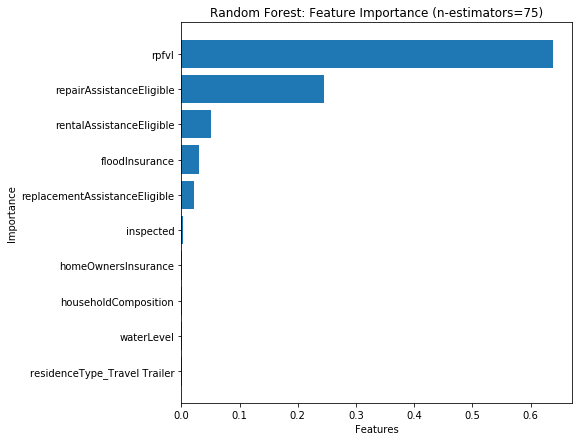

In [159]:
def plot_importance(data, model):

    # Feature importance
    df_trim = data.loc[:, data.columns != 'haAmount']
    importance = pd.DataFrame({'feature': df_trim.columns, 'importance': model.feature_importances_})
    importance.sort_values(by='importance', ascending=True, inplace=True)
    trimmed_features = importance.loc[importance['importance'] > 0.001]
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize = (7,7))
    ax.barh(trimmed_features['feature'], trimmed_features['importance'])
    ax.set_title('Random Forest: Feature Importance (n-estimators={})'.format(model.get_params()['n_estimators']))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    
    # Sort descending
    importance.sort_values(by='importance', ascending=False, inplace=True)
    
    return(importance)

# Plot importance
rf_features = plot_importance(data=df, model=rf)

### Clean data - RF

In [83]:
# Transform - no outliers
df_trim = transform_fema(df_clean)

# RandomForest - clean data
rf_trim, y_pred_rft, y_test_rft = random_forest(data=df_trim, n_estimators=75,
                                                              max_depth=10,
                                                              max_samples=0.8,
                                                              min_samples_leaf=1,
                                                              bootstrap=True)

# Save the model
pickle.dump(rf_trim, open('./models/rf-trim.sav', 'wb'))

Random Forest Regressor
Features: 34
Time (minutes): 11.2

R^2 score: 0.9517
MAE: 63.02
MSE: 334896.78
RMSE: 578.70

Actual amount:    $306,323,367.07
Predicted amount: $305,371,020.70
Difference: -952,346.37

Preds off by 20%: 2.73%


In [115]:
# Load saved model
rf_trim = pickle.load(open('./models/rf-trim.sav', 'rb'))
#print(rf_trim)

In [109]:
# RF trim - observations
rf_trim_df = pd.DataFrame(y_test_rft)
rf_trim_df.columns = ['Actuals']

# Predictions and errors
rf_trim_df['Predictions'] = y_pred_rft
rf_trim_df['Errors'] = y_pred_rft - y_test_rft

rf_trim_df.describe()

,Actuals,Predictions,Errors
count,637457.000000,637457.000000,637457.000000
mean,480.539655,479.045678,-1.493977
std,2633.518498,2560.655111,578.701194
min,0.000000,0.000000,-32071.900416
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,33300.000000,32678.523549,30321.013959


## XGBoost Regressor

https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

Hyperparameters:
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- Tree depth is controlled via the “max_depth” argument and defaults to 6.
- The learning rate can be controlled via the “eta” argument and defaults to 0.3.
- The number of samples used to fit each tree is specified by the “subsample” argument and can be set to a fraction of the training dataset size. By default, it is set to 1.0 to use the entire training dataset.
- The number of features used by each tree is taken as a random sample and is specified by the “colsample_bytree” argument and defaults to all features in the training dataset, e.g. 100 percent or a value of 1.0. 

In [85]:
# Best parameters using IHP GridSearch with min child weight
# Obtained from DecisionTrees notebook

# {'learning_rate': 0.05,
#  'max_depth': 10,
#  'min_child_weight': 1,
#  'n_estimators': 100,
#  'objective': 'reg:squarederror',
#  'subsample': 0.8}

In [86]:
def xg_boost(data=df_full, n_estimators=100, learning_rate=0.05, max_depth=10, min_child_weight=1, subsample=0.8, objective='reg:squarederror'):
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'haAmount']
    y = data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # XGBoost Regressor - fit the model
    xgb = XGBRegressor(n_estimators=n_estimators,
                       learning_rate=learning_rate,
                       max_depth=max_depth,
                       min_child_weight=min_child_weight,
                       subsample=subsample,
                       objective=objective,
                       random_state=42)
    
    xgb.fit(X_train, y_train)

    # Predict
    y_pred = xgb.predict(X_test)
    
    # Parameters and results
    print('XGBoost Regressor')
    print('Features: {}'.format(X_train.shape[1]))
    print('Time (minutes): {:.1f}'.format((time.time() - start_time)/60))
    
    print('\nR^2 score: {:.4f}'.format(metrics.r2_score(y_test, y_pred)))
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    # Dollar amounts
    print('\nActual amount:    ${:,.2f}'.format(y_test.sum()))
    print('Predicted amount: ${:,.2f}'.format(y_pred.sum()))
    print('Difference: {:,.2f}'.format(y_pred.sum() - y_test.sum()))
    
    # Predictions off by more than 20%
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['diff'] = results_df['predicted'] - results_df['actual']    
    results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)    
    print('\nPreds off by 20%: {:.2f}%'.format( 
          len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100))  
    
    return(xgb, y_pred, y_test)

### Full Data - XGB

In [88]:
# Transform
df = transform_fema(df_full)

# XGBoost - full data
xg, y_pred_xg, y_test_xg = xg_boost(data=df, n_estimators=100,
                                             learning_rate=0.05,
                                             max_depth=10,
                                             min_child_weight=1,
                                             subsample=0.8,
                                             objective='reg:squarederror')

# Save the model
pickle.dump(xg, open('./models/xgb.sav', 'wb'))

XGBoost Regressor
Features: 34
Time (minutes): 6.3

R^2 score: 0.9549
MAE: 71.49
MSE: 289001.08
RMSE: 537.59

Actual amount:    $387,597,186.13
Predicted amount: $384,772,928.00
Difference: -2,824,258.13

Preds off by 20%: 4.40%


In [114]:
# Load saved model
xg = pickle.load(open('./models/xgb.sav', 'rb'))
#print(xg)

In [110]:
# XG - observations
xg_df = pd.DataFrame(y_test_xg)
xg_df.columns = ['Actuals']

# Predictions and errors
xg_df['Predictions'] = y_pred_xg
xg_df['Errors'] = y_pred_xg - y_test_xg

xg_df.describe()

,Actuals,Predictions,Errors
count,707064.000000,707064.000000,707064.000000
mean,548.178363,544.142700,-3.994424
std,2530.463875,2448.612793,537.573748
min,0.000000,-529.305786,-30345.313477
25%,0.000000,0.003385,0.003385
50%,0.000000,0.003385,0.003385
75%,0.000000,0.003385,0.003385
max,34788.830000,33308.621094,30057.887109


### Clean data - XGB

In [90]:
# Transform - no outliers
df_trim = transform_fema(df_clean)

# XGBoost - clean data
xg_trim, y_pred_xgt, y_test_xgt = xg_boost(data=df_trim, n_estimators=100,
                                                         learning_rate=0.05,
                                                         max_depth=10,
                                                         min_child_weight=1,
                                                         subsample=0.8,
                                                         objective='reg:squarederror')

# Save the model
pickle.dump(xg_trim, open('./models/xgb-trim.sav', 'wb'))

XGBoost Regressor
Features: 34
Time (minutes): 5.3

R^2 score: 0.9524
MAE: 61.80
MSE: 330130.51
RMSE: 574.57

Actual amount:    $306,323,367.07
Predicted amount: $303,583,232.00
Difference: -2,740,135.07

Preds off by 20%: 2.59%


In [113]:
# Load saved model
xg_trim = pickle.load(open('./models/xgb-trim.sav', 'rb'))
#print(xg_trim)

In [112]:
# XG trim - observations
xg_trim_df = pd.DataFrame(y_test_xgt)
xg_trim_df.columns = ['Actuals']

# Predictions and errors
xg_trim_df['Predictions'] = y_pred_xgt
xg_trim_df['Errors'] = y_pred_xgt - y_test_xgt

xg_trim_df.describe()

,Actuals,Predictions,Errors
count,637457.000000,637457.000000,637457.000000
mean,480.539655,476.232880,-4.298534
std,2633.518498,2551.380371,574.554217
min,0.000000,-921.824829,-31994.159058
25%,0.000000,0.003779,0.003779
50%,0.000000,0.003779,0.003779
75%,0.000000,0.003779,0.003779
max,33300.000000,33318.218750,29897.873750


## Grid Search

### Random Forest

In [184]:
def random_forest_optimizer(data=df):
    '''Fit GridSearchCV using Random Forest Regressor for various
    parameters. Accepts input of full_data and returns (prints)
    the best model score and corresponding parameters.
    '''
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'haAmount']
    y = data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # Parameters
    model = RandomForestRegressor(random_state=42)
    param_grid = {'n_estimators': np.array([75, 100, 125]),
                  'max_depth': np.array([8, 9, 10]),
                  'max_samples': np.array([0.8, 0.9, None]),
                  'min_samples_leaf': np.array([1, 5, 10]),
                  'criterion': ['mse']}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, p-9aram_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Make predictions
    y_pred = grid_search.predict(X_test)

    # summarize the results of the grid search
    print('Random Forest Regressor')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    
    print('\ncriterion: {}'.format(grid_search.best_estimator_.criterion))
    print('n_estimator: {}'.format(grid_search.best_estimator_.n_estimators))
    print('max_depth: {}'.format(grid_search.best_estimator_.max_depth))
    print('max_samples: {}'.format(grid_search.best_estimator_.max_samples))
    print('min_samples_leaf: {}'.format(grid_search.best_estimator_.min_samples_leaf))

    print('\nTime (minutes): {:.1f}'.format((time.time() - start_time)/60))
    
    return(grid_search, y_pred, y_test)

In [186]:
# Transform - no outliers
df_trim = transform_fema(df_clean)

# Random Forest with Grid Search
rf_best, y_pred_rfbest, y_test_rfbest = random_forest_optimizer(data=df_trim)

# Save the model
pickle.dump(rf_best, open('./models/rf-best.sav', 'wb'))

Random Forest Regressor
Best score: -326908.304

criterion: mse
n_estimator: 125
max_depth: 10
max_samples: 0.9
min_samples_leaf: 5

Time (minutes): 1879.8


### Clean Data - Best Random Forest

In [191]:
# Transform
df_trim = transform_fema(df_clean)

# RandomForest - full data
rf_best, y_pred_rfb, y_test_rfb = random_forest(data=df_trim, n_estimators=125,
                                                              max_depth=10,
                                                              max_samples=0.9,
                                                              min_samples_leaf=5,
                                                              criterion='mse')

# Save the model
pickle.dump(rf_best, open('./models/rf-best.sav', 'wb'))

Random Forest Regressor
Features: 34
Time (minutes): 16.4

R^2 score: 0.9519
MAE: 62.82
MSE: 333776.89
RMSE: 577.73

Actual amount:    $306,323,367.07
Predicted amount: $305,457,100.07
Difference: -866,267.00

Preds off by 20%: 2.74%


In [5]:
# Load saved model
rf_best = pickle.load(open('./models/rf-best.sav', 'rb'))
print(rf_best)

RandomForestRegressor(max_depth=10, max_samples=0.9, min_samples_leaf=5,
                      n_estimators=125, random_state=42)


### Plotting a Tree

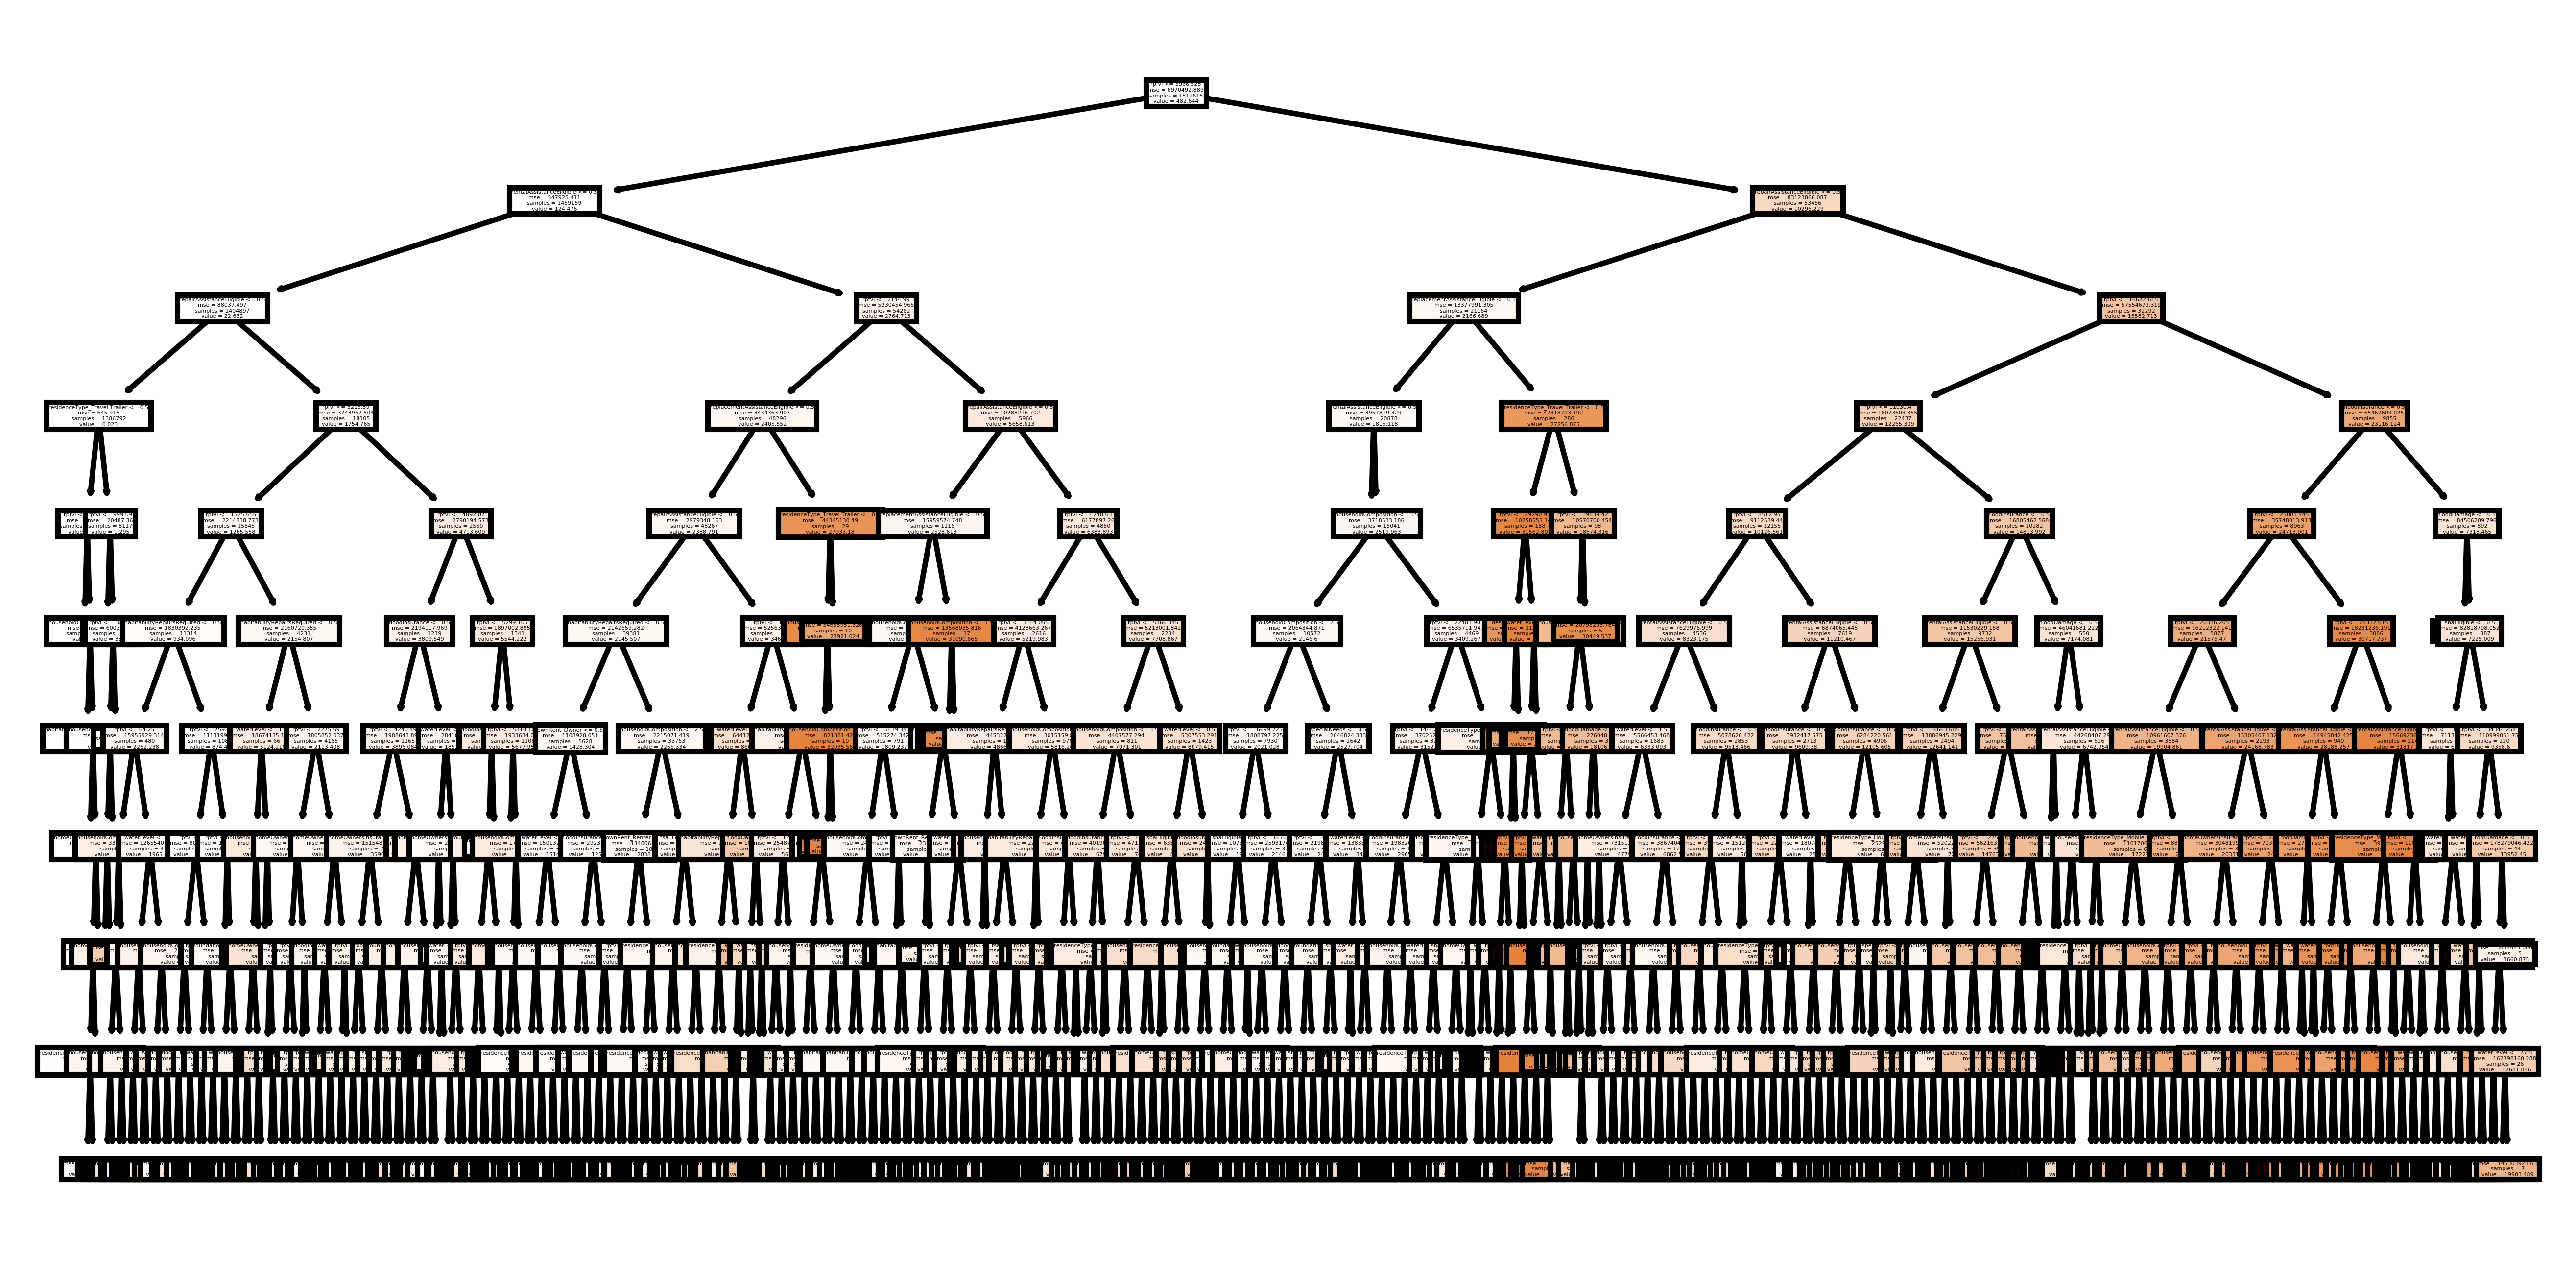

In [13]:
# Transform - no outliers
df_trim = transform_fema(df_clean)

# Names
feature_names = df_trim.loc[:, df_trim.columns != 'haAmount'].columns
target_name = df_trim.loc[:, df_trim.columns == 'haAmount'].columns

# Plot tree
fig, axes = plt.subplots(figsize = (8,4), dpi=800)

# Tree from forest
tree.plot_tree(rf_best.estimators_[0],
               feature_names = feature_names, 
               class_names=target_name,
               filled = True);

fig.savefig('rf_tree.png')